# Plotting barotropic streamfunction in North Atlantic (gyre)

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
%matplotlib inline

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40769,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:46855,Total threads: 4
Dashboard: /proxy/46391/status,Memory: 18.29 GiB
Nanny: tcp://127.0.0.1:36107,


In [3]:
session_CM2  = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt_CM2_025 = 'cj877'
expt_CM2_1   = 'bz687'

In [4]:
# OM2 database
session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt_OM2_025 = '025deg_jra55_ryf9091_gadi'
expt_OM2_1   = '1deg_jra55_ryf9091_gadi'

If you get a 'read-only database' warning, it is because the database has not finished building. 

In [7]:
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'
fig_path = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

In [6]:
# Plotting info
ft_size = 16
plt.rcParams.update({'font.size': ft_size})

#### Mask for the North Atlantic

In [8]:
def get_mask(expt, session, coord='ty'):
    
    # Approximate region
    lat_slice = slice(0, 65)
    lon_slice = slice(-99, 25)
    
    # Mask based on bathymetry (0 or 1)
    ht = cc.querying.getvar(expt, 'ht', session, n=-1)#.sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice) 
    land_mask = ~ht.isnull()
    
    # Adjust coordinates to match the ones from our variable of interest
    if coord == 'ty':
        var = cc.querying.getvar(expt, 'tx_trans_int_z', session, n=1)
        land_mask.coords['xt_ocean'] = var.xu_ocean.values
        land_mask = land_mask.rename({'xt_ocean':'xu_ocean'})
        # Redefine area
        land_mask = land_mask.sel(xu_ocean=lon_slice).sel(yt_ocean=lat_slice) 
        map1 = land_mask.where(land_mask.yt_ocean < 9).where(land_mask.xu_ocean > -65).fillna(0)
        map2 = land_mask.where(land_mask.yt_ocean < 15.5).where(land_mask.yt_ocean > 9).where(land_mask.xu_ocean > -83.7).fillna(0)
        map3 = land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15.5).where(land_mask.xu_ocean > -93.3).fillna(0)
        map4 = land_mask.where(land_mask.yt_ocean > 17).fillna(0)
    elif coord == 'tx':
        var = cc.querying.getvar(expt, 'ty_trans_int_z', session, n=1)
        land_mask.coords['yt_ocean'] = var.yu_ocean.values
        land_mask = land_mask.rename({'yt_ocean':'yu_ocean'})
        # Redefine area
        land_mask = land_mask.sel(xt_ocean=lon_slice).sel(yu_ocean=lat_slice) 
        map1 = land_mask.where(land_mask.yu_ocean < 9).where(land_mask.xt_ocean > -65).fillna(0)
        map2 = land_mask.where(land_mask.yu_ocean < 15.5).where(land_mask.yu_ocean > 9).where(land_mask.xt_ocean > -83.7).fillna(0)
        map3 = land_mask.where(land_mask.yu_ocean < 17).where(land_mask.yu_ocean > 15.5).where(land_mask.xt_ocean > -93.3).fillna(0)
        map4 = land_mask.where(land_mask.yu_ocean > 17).fillna(0)
        
    sector_map  = map1 + map2 + map3 + map4
    sector_mask = sector_map.where(sector_map > 0)
    
    return sector_mask

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, cal

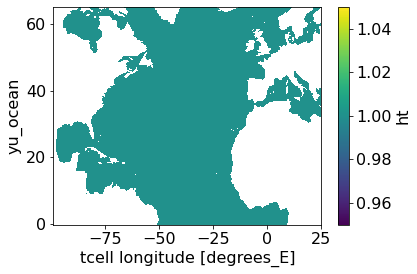

In [8]:
mask_CM2_025_tx = get_mask(expt_CM2_025, session_CM2, coord='tx')
mask_CM2_025_tx.plot();

In [51]:
mask_1_tx = get_mask(expt_CM2_1, session_CM2, coord='tx')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


#### Barotropic streamfunction

Explainer adapted from [cosima recipe](https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Barotropic_Streamfunction.ipynb).

Calculate the mean barotropic stream function by integrating the time-mean zonal transport in latitude starting from some arbitrary latitude $y0$:

$$\psi(x, y) = -\int_{y_0}^y \frac{\overline{T^{x}(x, y')}}{\rho}\, \mathrm{d}y',$$

where $T^{x}(x, y)$ is the depth integrated mass transport, the overline denotes time-mean, $y_0$ is any arbirtrary latitude (in our case, the equator), and $\rho$ is the mean deansity of sea water (to convert mass transport to volume transport).

The minus sign above is merely a matter of convenction so that positive values of streamfunction denote eastward flow.

Variable `tx_trans_int_z` contains the instantaneous depth-intergrated zonal transport multiplied with the $\Delta y$ of each cell:  
<center> tx_trans_int_z$=T^{x}(x, y)\,\mathrm{d}y$.</center>

Alternatively, integrate the time-mean meridional transport in longitude from some arbitraty longitude (e.g. western boundary) with a positive sign:

$$\psi(x, y) = \int_{x_0}^x \frac{\overline{T^{y}(x', y)}}{\rho}\, \mathrm{d}x',$$

This can be useful for calculating the gyres in the Northern Hemisphere where there are some lateral boundaries. 



Finally, divide by mean $10^6$ to convect units from m$^3$/s to Sv.

In [9]:
def get_btr_streamfunction(expt, session, coord='ty', start_time='0001-01-01', end_time='0001-12-31', frequency='1 monthly'):
    
    rho = 1035.0 # kg/m^3    (or use 1036?)
    lat_slice = slice(0, 65)
    lon_slice = slice(-99, 25)
    
    mask = get_mask(expt, session, coord)
    
    if coord == 'ty':
        var = cc.querying.getvar(expt, 'tx_trans_int_z', session, start_time=start_time, end_time=end_time, frequency=frequency)
        var = var.sel(time=slice(start_time, end_time)).sel(xu_ocean=lon_slice).sel(yt_ocean=lat_slice).mean('time')
        psi = (-var * mask).cumsum('yt_ocean') / (1e6*rho)
    
    elif coord == 'tx':
        var = cc.querying.getvar(expt, 'ty_trans_int_z', session, start_time=start_time, end_time=end_time, frequency=frequency)
        var = var.sel(time=slice(start_time, end_time)).sel(xt_ocean=lon_slice).sel(yu_ocean=lat_slice).mean('time')
        psi = (var * mask).cumsum('xt_ocean') / (1e6*rho)
    
    return psi, mask

def get_btr_streamfunction_nomask(expt, session, mask, coord='ty', start_time='0001-01-01', end_time='0001-12-31', frequency='1 monthly'):
    
    rho = 1035.0 # kg/m^3    (or use 1036?)
    lat_slice = slice(0, 65)
    lon_slice = slice(-99, 25)
    
    if coord == 'ty':
        var = cc.querying.getvar(expt, 'tx_trans_int_z', session, start_time=start_time, end_time=end_time, frequency=frequency)
        var = var.sel(time=slice(start_time, end_time)).sel(xu_ocean=lon_slice).sel(yt_ocean=lat_slice).mean('time')
        psi = (-var * mask).cumsum('yt_ocean') / (1e6*rho)
    
    elif coord == 'tx':
        var = cc.querying.getvar(expt, 'ty_trans_int_z', session, start_time=start_time, end_time=end_time, frequency=frequency)
        var = var.sel(time=slice(start_time, end_time)).sel(xt_ocean=lon_slice).sel(yu_ocean=lat_slice).mean('time')
        psi = (var * mask).cumsum('xt_ocean') / (1e6*rho)
    
    return psi

#### Pos and neg phases of multidecadal variability

Get years of pos and neg extremes

In [10]:
amo_index = xr.open_dataarray(path_to_data + 'amo_index.nc')
year_pos_amo = amo_index.year.where(amo_index > amo_index.std()).dropna(dim='year')[3:]
year_neg_amo = amo_index.year.where(amo_index < -amo_index.std()).dropna(dim='year')

In [ ]:
mask_CM2_025 = get_mask(expt_CM2_025, session_CM2, coord='tx')

In [16]:
%%time
# Positive anomaly
length = np.zeros(len(year_pos_amo))
for ii in range(len(year_pos_amo)):
    length[ii] = len(str(int(year_pos_amo[ii])))

for ii in range((len(year_pos_amo))):
    
    if length[ii] == 2:
        year = '00' + str(int(year_pos_amo.values[ii]))
    elif length[ii] == 3:
        year = '0' + str(int(year_pos_amo.values[ii]))
    
    psi = get_btr_streamfunction_nomask(expt_CM2_025, session_CM2, mask_CM2_025, coord='tx', start_time=str(year)+'-01-01', end_time=str(year)+'-12-31', frequency='1 monthly')
    
    if ii == 0:
        psi_pos = psi
    if ii > 0:
        psi_pos = xr.concat([psi_pos, psi], "new_dim")
    

CPU times: user 21 s, sys: 7.31 s, total: 28.3 s
Wall time: 33.7 s


In [18]:
%%time
# Negative anomaly
length = np.zeros(len(year_neg_amo))
for ii in range(len(year_neg_amo)):
    length[ii] = len(str(int(year_neg_amo[ii])))

for ii in range((len(year_neg_amo))):
    
    if length[ii] == 2:
        year = '00' + str(int(year_neg_amo.values[ii]))
    elif length[ii] == 3:
        year = '0' + str(int(year_neg_amo.values[ii]))
    
    psi = get_btr_streamfunction_nomask(expt_CM2_025, session_CM2, mask_CM2_025, coord='tx', start_time=str(year)+'-01-01', end_time=str(year)+'-12-31', frequency='1 monthly')
    
    if ii == 0:
        psi_neg = psi
    if ii > 0:
        psi_neg = xr.concat([psi_neg, psi], "new_dim")
    

CPU times: user 20.3 s, sys: 7.09 s, total: 27.3 s
Wall time: 35.3 s


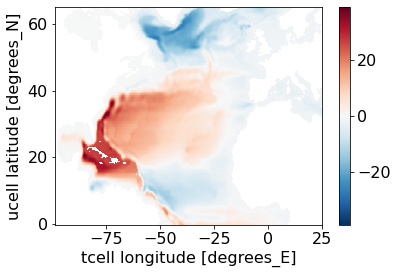

In [17]:
(psi_pos.mean('new_dim')*mask_CM2_025).plot()

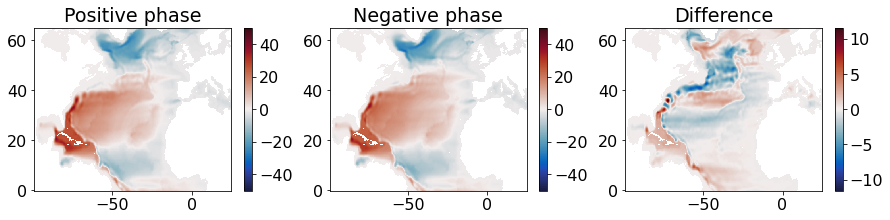

In [21]:
fig = plt.figure(figsize=(15,3))

plt.subplot(131)
plt.title('Positive phase')
(psi_pos.mean('new_dim')*mask_CM2_025).plot(add_labels=False, vmin=-50, vmax=50, cmap=cm.cm.balance)

plt.subplot(132)
plt.title('Negative phase')
(psi_neg.mean('new_dim')*mask_CM2_025).plot(add_labels=False, vmin=-50, vmax=50, cmap=cm.cm.balance)

plt.subplot(133)
plt.title('Difference')
((psi_pos.mean('new_dim')-psi_neg.mean('new_dim'))*mask_CM2_025).plot(add_labels=False, cmap=cm.cm.balance)#, vmin=-25, vmax=25);

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_btr_streamfunction_pos_neg_phases.png'
    plt.savefig(fig_path + fig_name);

In [32]:
%%time
psi_CM2_025_210_220 = get_btr_streamfunction(expt_CM2_025, session_CM2, coord='tx', start_time='0210-01-01', end_time='0219-12-31')

CPU times: user 7.34 s, sys: 699 ms, total: 8.03 s
Wall time: 11.2 s


In [33]:
psi_CM2_025_260_270 = get_btr_streamfunction(expt_CM2_025, session_CM2, coord='tx', start_time='0260-01-01', end_time='0269-12-31')

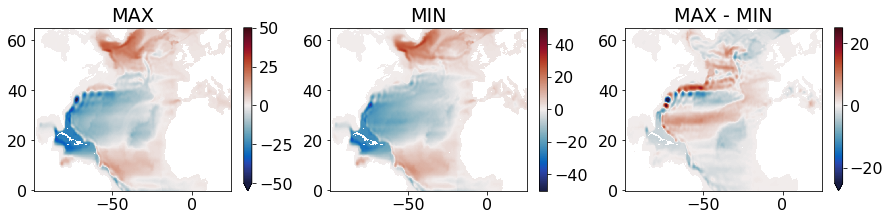

In [46]:
fig = plt.figure(figsize=(15,3))

plt.subplot(131)
plt.title('MAX')
(psi_CM2_025_210_220*mask_025_tx).plot(add_labels=False, vmin=-50, vmax=50, cmap=cm.cm.balance)

plt.subplot(132)
plt.title('MIN')
(psi_CM2_025_260_270*mask_025_tx).plot(add_labels=False, vmin=-50, vmax=50, cmap=cm.cm.balance)

plt.subplot(133)
plt.title('MAX - MIN')
((psi_CM2_025_210_220-psi_CM2_025_260_270)*mask_025_tx).plot(add_labels=False, cmap=cm.cm.balance, vmin=-25, vmax=25);

#### Comparison between models

In [73]:
# CM2, 025
mask_CM2_025_tx = get_mask(expt_CM2_025, session_CM2, coord='tx')

In [9]:
# OM2, 1/4
psi_OM2_025_210_220, mask_OM2_025_tx = get_btr_streamfunction(expt_OM2_025, session_OM2, coord='tx', start_time='2190-01-01', end_time='2199-12-31')

In [ ]:
# CM2, 1
psi_CM2_1_210_220, mask_CM2_1_tx = get_btr_streamfunction(expt_CM2_1, session_CM2, coord='tx', start_time='0210-01-01', end_time='0219-12-31')

In [11]:
# OM2, 1
psi_OM2_1_210_220, mask_OM2_1_tx = get_btr_streamfunction(expt_OM2_1, session_OM2, coord='tx', start_time='2190-01-01', end_time='2199-12-31')

In [ ]:
lon_slice = slice(-99, 25)
rho = 1035.0 # kg/m^3    (or use 1036?)
lat_slice = slice(0, 65)

var_OM2 = cc.querying.getvar(expt_OM2_1, 'ty_trans_int_z', session_OM2, start_time='2190-01-01', end_time='2199-01-01', frequency='1 monthly')
var_OM2 = var_OM2.sel(time=slice('2190-01-01', '2199-01-01')).sel(xt_ocean=lon_slice).sel(yu_ocean=lat_slice).mean('time')
psi_OM2 = (var_OM2 * mask_OM2_1_tx).cumsum('xt_ocean') / (1e6*rho)

var_CM2 = cc.querying.getvar(expt_CM2_1, 'ty_trans_int_z', session_CM2, start_time='0210-01-01', end_time='0219-01-01', frequency='1 monthly')
var_CM2 = var_CM2.sel(time=slice('0210-01-01', '0219-01-01')).sel(xt_ocean=lon_slice).sel(yu_ocean=lat_slice).mean('time')
psi_CM2 = (var_CM2 * mask_CM2_1_tx).cumsum('xt_ocean') / (1e6*rho)

var_OM2_tx_trans = cc.querying.getvar(expt_OM2_1, 'tx_trans_int_z', session_OM2, start_time='2190-01-01', end_time='2199-01-01', frequency='1 monthly')
var_OM2_tx_trans = var_OM2_tx_trans.sel(time=slice('2190-01-01', '2199-01-01')).sel(xu_ocean=lon_slice).sel(yt_ocean=lat_slice).mean('time')

var_CM2_tx_trans = cc.querying.getvar(expt_CM2_1, 'tx_trans_int_z', session_CM2, start_time='0210-01-01', end_time='0219-01-01', frequency='1 monthly')
var_CM2_tx_trans = var_CM2_tx_trans.sel(time=slice('0210-01-01', '0219-01-01')).sel(xu_ocean=lon_slice).sel(yt_ocean=lat_slice).mean('time')

In [17]:
# Try fooling the system
var_test = var_CM2.copy(deep=True)
var_test[:,:] = var_OM2.values

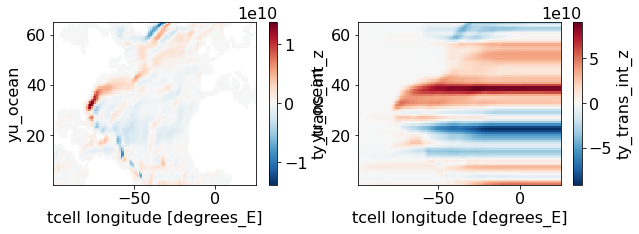

In [69]:
fig = plt.figure(figsize=(10,3))

plt.subplot(121)
var_OM2.plot()

plt.subplot(122)
var_OM2.cumsum('xt_ocean', skipna=True).plot()#vmin=-1000, vmax=1000, cmap='bwr')

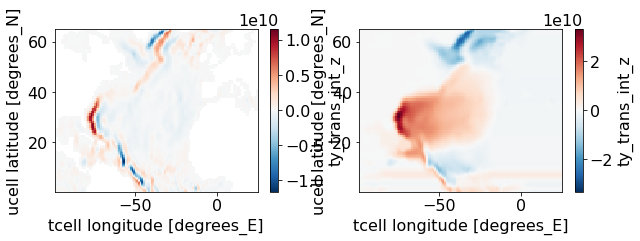

In [24]:
fig = plt.figure(figsize=(10,3))

plt.subplot(121)
var_CM2.plot()

plt.subplot(122)
var_CM2.cumsum('xt_ocean').plot()

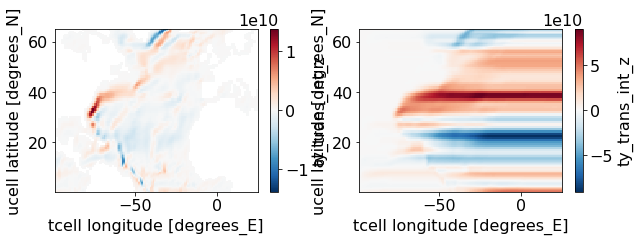

In [18]:
fig = plt.figure(figsize=(10,3))

plt.subplot(121)
var_test.plot()

plt.subplot(122)
var_test.cumsum('xt_ocean').plot()

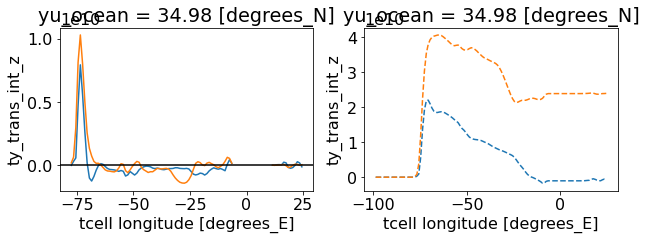

In [52]:
fig = plt.figure(figsize=(10,3))

plt.subplot(121)
var_CM2.sel(yu_ocean=35, method='nearest').plot(color='C0')
var_OM2.sel(yu_ocean=35, method='nearest').plot(color='C1')
plt.axhline(0, color='k')

plt.subplot(122)
var_CM2.cumsum('xt_ocean').sel(yu_ocean=35, method='nearest').plot(color='C0', linestyle='--')
var_OM2.cumsum('xt_ocean').sel(yu_ocean=35, method='nearest').plot(color='C1', linestyle='--')

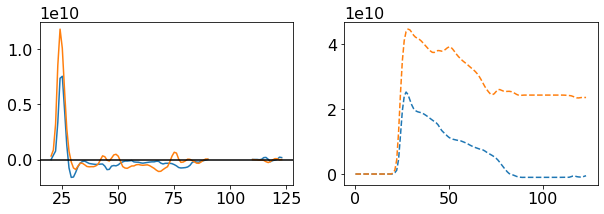

In [55]:
fig = plt.figure(figsize=(10,3))

plt.subplot(121)
plt.plot(var_CM2.sel(yu_ocean=34, method='nearest').values, color='C0')
plt.plot(var_OM2.sel(yu_ocean=34, method='nearest').values, color='C1')
plt.axhline(0, color='k')

plt.subplot(122)
plt.plot(var_CM2.cumsum('xt_ocean').sel(yu_ocean=34, method='nearest').values, color='C0', linestyle='--')
plt.plot(var_OM2.cumsum('xt_ocean').sel(yu_ocean=34, method='nearest').values, color='C1', linestyle='--')

In [59]:
#(var_OM2 - var_CM2)#.plot()
var_CM2

<xarray.DataArray 'ty_trans_int_z' (yu_ocean: 108, xt_ocean: 124)>
dask.array<mean_agg-aggregate, shape=(108, 124), dtype=float32, chunksize=(108, 124), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -98.5 -97.5 -96.5 -95.5 ... 21.5 22.5 23.5 24.5
  * yu_ocean  (yu_ocean) float64 0.3333 0.6667 1.0 1.333 ... 64.08 64.54 65.0

In [66]:
var_OM2.coords['yu_ocean'] = var_CM2.yu_ocean.values

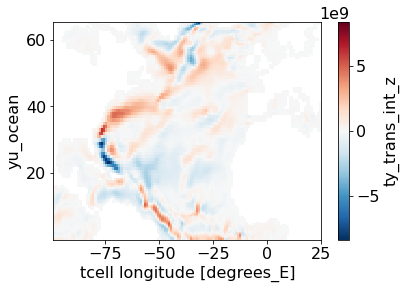

In [68]:
(var_OM2-var_CM2).plot()

#### Test Pacific basin

In [ ]:
lon_slice = slice(-250, -100)
rho = 1035.0 # kg/m^3    (or use 1036?)
lat_slice = slice(20, 60)

var_OM2 = cc.querying.getvar(expt_OM2_1, 'ty_trans_int_z', session_OM2, start_time='2190-01-01', end_time='2199-01-01', frequency='1 monthly')
var_OM2 = var_OM2.sel(time=slice('2190-01-01', '2199-01-01')).sel(xt_ocean=lon_slice).sel(yu_ocean=lat_slice).mean('time')
psi_OM2 = (var_OM2 * mask_OM2_1_tx).cumsum('xt_ocean') / (1e6*rho)

var_CM2 = cc.querying.getvar(expt_CM2_1, 'ty_trans_int_z', session_CM2, start_time='0210-01-01', end_time='0219-01-01', frequency='1 monthly')
var_CM2 = var_CM2.sel(time=slice('0210-01-01', '0219-01-01')).sel(xt_ocean=lon_slice).sel(yu_ocean=lat_slice).mean('time')
psi_CM2 = (var_CM2 * mask_CM2_1_tx).cumsum('xt_ocean') / (1e6*rho)

var_OM2_tx_trans = cc.querying.getvar(expt_OM2_1, 'tx_trans_int_z', session_OM2, start_time='2190-01-01', end_time='2199-01-01', frequency='1 monthly')
var_OM2_tx_trans = var_OM2_tx_trans.sel(time=slice('2190-01-01', '2199-01-01')).sel(xu_ocean=lon_slice).sel(yt_ocean=lat_slice).mean('time')

var_CM2_tx_trans = cc.querying.getvar(expt_CM2_1, 'tx_trans_int_z', session_CM2, start_time='0210-01-01', end_time='0219-01-01', frequency='1 monthly')
var_CM2_tx_trans = var_CM2_tx_trans.sel(time=slice('0210-01-01', '0219-01-01')).sel(xu_ocean=lon_slice).sel(yt_ocean=lat_slice).mean('time')

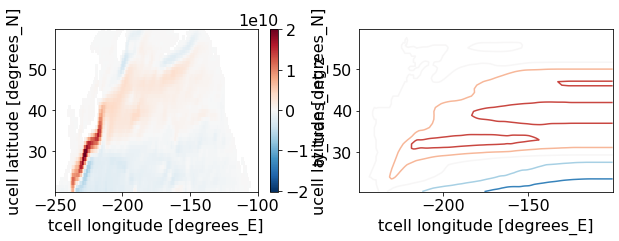

In [74]:
fig = plt.figure(figsize=(10,3))

plt.subplot(121)
var_OM2.plot()

plt.subplot(122)
var_OM2.cumsum('xt_ocean', skipna=True).plot.contour()#vmin=-1000, vmax=1000, cmap='bwr')

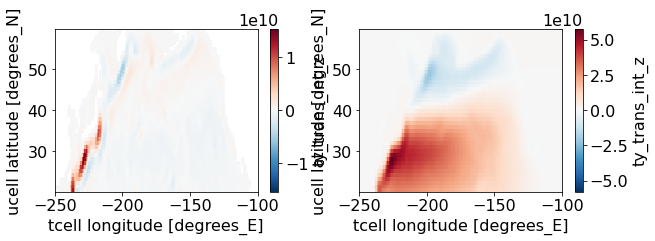

In [72]:
fig = plt.figure(figsize=(10,3))

plt.subplot(121)
var_CM2.plot()

plt.subplot(122)
var_CM2.cumsum('xt_ocean', skipna=True).plot()#vmin=-1000, vmax=1000, cmap='bwr')

#### Integrate zonal velocity in meridional direction

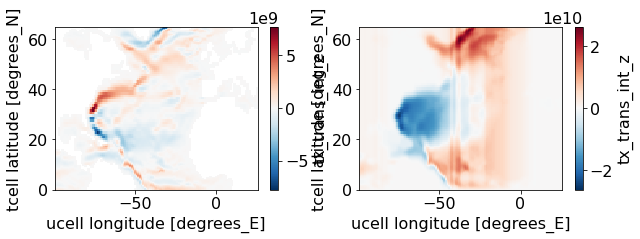

In [42]:
fig = plt.figure(figsize=(10,3))

plt.subplot(121)
var_OM2_tx_trans.plot()

plt.subplot(122)
var_OM2_tx_trans.cumsum('yt_ocean').plot()

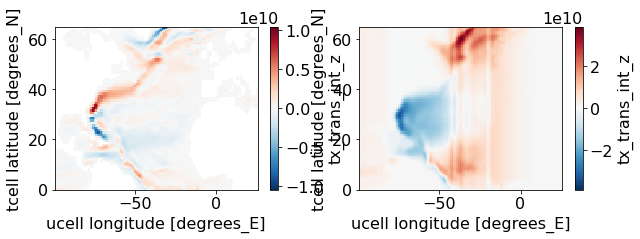

In [43]:
fig = plt.figure(figsize=(10,3))

plt.subplot(121)
var_CM2_tx_trans.plot()

plt.subplot(122)
var_CM2_tx_trans.cumsum('yt_ocean').plot()

In [39]:
var_OM2_tx_trans

<xarray.DataArray 'tx_trans_int_z' (yt_ocean: 108, xu_ocean: 125)>
dask.array<mean_agg-aggregate, shape=(108, 125), dtype=float32, chunksize=(108, 125), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 0.1662 0.5005 0.8329 ... 63.85 64.31 64.77
  * xu_ocean  (xu_ocean) float64 -99.0 -98.0 -97.0 -96.0 ... 22.0 23.0 24.0 25.0

In [40]:
var_CM2_tx_trans

<xarray.DataArray 'tx_trans_int_z' (yt_ocean: 108, xu_ocean: 125)>
dask.array<mean_agg-aggregate, shape=(108, 125), dtype=float32, chunksize=(108, 125), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 0.1662 0.5005 0.8329 ... 63.85 64.31 64.77
  * xu_ocean  (xu_ocean) float64 -99.0 -98.0 -97.0 -96.0 ... 22.0 23.0 24.0 25.0

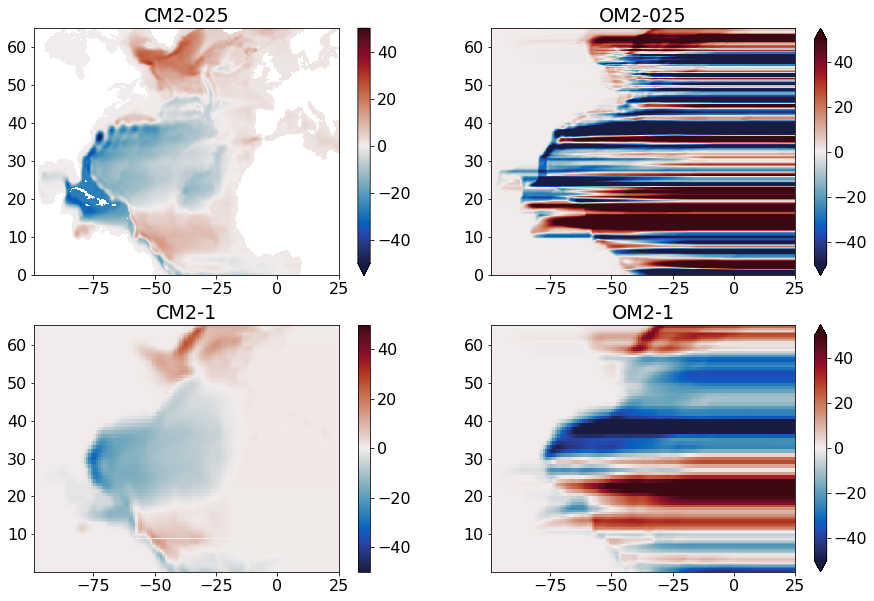

In [52]:
fig = plt.figure(figsize=(15,10))

plt.subplot(221)
plt.title('CM2-025')
(psi_CM2_025_210_220*mask_025_tx).plot(add_labels=False, vmin=-50, vmax=50, cmap=cm.cm.balance)

plt.subplot(222)
plt.title('OM2-025')
psi_OM2_025_210_220.plot(add_labels=False, vmin=-50, vmax=50, cmap=cm.cm.balance)

plt.subplot(224)
plt.title('OM2-1')
psi_OM2_1_210_220.plot(add_labels=False, vmin=-50, vmax=50, cmap=cm.cm.balance)

plt.subplot(223)
plt.title('CM2-1')
psi_CM2_1_210_220.plot(add_labels=False, vmin=-50, vmax=50, cmap=cm.cm.balance);


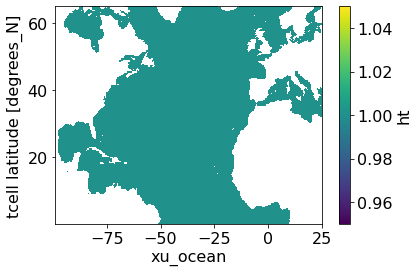

In [108]:
mask.plot()

In [18]:
rho = 1035.0 # kg/m^3    (or use 1036?)
lat_slice = slice(0, 65)
lon_slice = slice(-99, 25)

mask = get_mask(expt_CM2_025, session_CM2)

var = cc.querying.getvar(expt_CM2_025, 'ty_trans_int_z', session_CM2, start_time='0001-01-01', end_time='0001-12-31', frequency='1 monthly')
var = var.sel(time=slice('0001-01-01', '0001-12-31')).sel(xt_ocean=lon_slice).sel(yu_ocean=lat_slice).mean('time')

#psi = (-var * mask).cumsum('xt_ocean') / (1e6*rho)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, cal

In [14]:
%%time
test = get_btr_streamfunction(expt_CM2_025, session_CM2)

CPU times: user 6.25 s, sys: 435 ms, total: 6.68 s
Wall time: 6.23 s


In [16]:
test

<xarray.DataArray (yu_ocean: 346, xt_ocean: 496, yt_ocean: 345, xu_ocean: 497)>
dask.array<truediv, shape=(346, 496, 345, 497), dtype=float64, chunksize=(303, 496, 303, 497), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -98.88 -98.62 -98.38 ... 24.38 24.62 24.88
  * yu_ocean  (yu_ocean) float64 0.0 0.25 0.5 0.75 ... 64.65 64.76 64.87 64.97
  * xu_ocean  (xu_ocean) float64 -99.0 -98.75 -98.5 -98.25 ... 24.5 24.75 25.0
  * yt_ocean  (yt_ocean) float64 0.125 0.375 0.625 0.875 ... 64.71 64.81 64.92

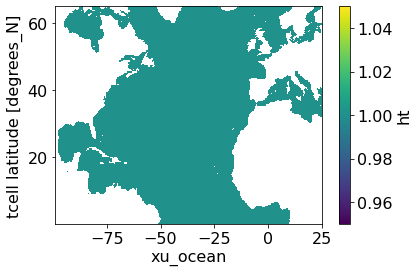

In [57]:
mask.plot()

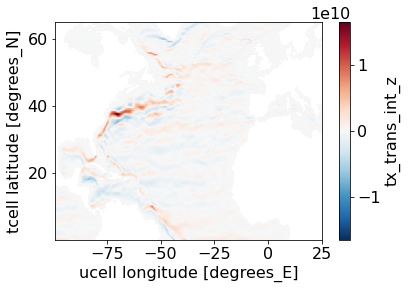

In [58]:
var.plot()

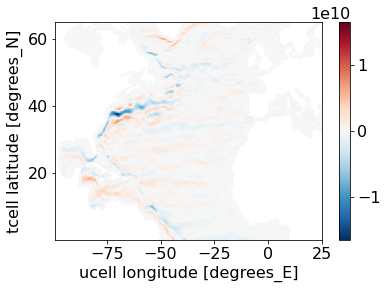

In [63]:
(-var*mask).plot();

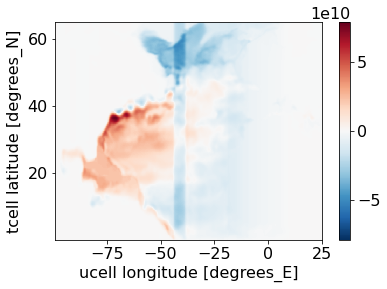

In [69]:
(-var*mask).cumsum('yt_ocean').plot();

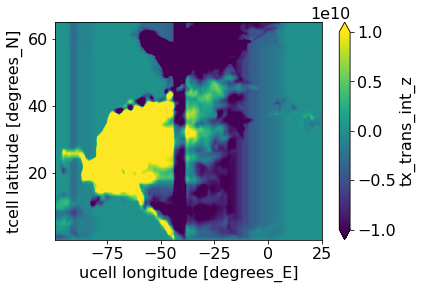

In [75]:
(-var).cumsum('yt_ocean').plot(vmin=-1e10, vmax=1e10);

In [91]:
#var.['yt_ocean'] = np.nan
var[0,:] = 0


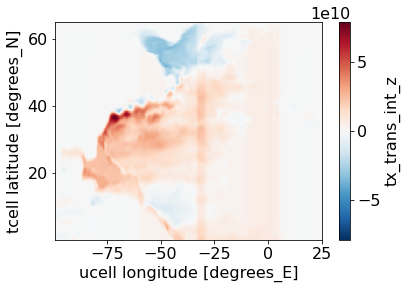

In [92]:
(var)[::-1,:].cumsum('yt_ocean')[::-1,:].plot()

In [86]:
var[::-1,:]

<xarray.DataArray 'tx_trans_int_z' (yt_ocean: 345, xu_ocean: 497)>
dask.array<getitem, shape=(345, 497), dtype=float32, chunksize=(303, 497), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -99.0 -98.75 -98.5 -98.25 ... 24.5 24.75 25.0
  * yt_ocean  (yt_ocean) float64 64.92 64.81 64.71 64.6 ... 0.625 0.375 0.125

- <del>test np.nancumsum
- test other variable (e.g. temp)
- zoom to problematic region - what's different?
- land mask not what cumsum expects? from var (nans on land) to cumsum with 0 on land?